<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Copy_of_Acc_Focal_Loss_ResNet50_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [1]:
!nvidia-smi

Thu May 28 13:16:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install runai

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
import runai.ga.keras

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

# **Clone Data**

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

fatal: destination path 'ham10000-with-one-image-folder' already exists and is not an empty directory.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7
STEPS = 16

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [8]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['dx'])
name_as_indexes_train = encoder.transform(train['dx']) 
train['label'] = name_as_indexes_train

In [0]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_val = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_val

In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [15]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [17]:
ga_optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [28-05-2020 13:16:51.558] [644] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# **Build Model**

### **Use ResNet50 + fine tuning**

In [0]:
def build_model():
  base_model = keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = BatchNormalization()(fc_layer)
  dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(dropout_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=ga_optimizer, loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])
  return model

In [23]:
model = build_model()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### **Architecture**

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### **Callbacks**

In [0]:
model_path = '/content/Acc_Focal-Loss_ResNet50_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [30]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=EPOCHS,
                            callbacks=cb_list)


Epoch 1/100
197/197 [==============================] - 152s 772ms/step - loss: 0.2227 - accuracy: 0.2058 - val_loss: 0.1772 - val_accuracy: 0.2861

Epoch 00001: val_loss improved from -inf to 0.17716, saving model to /content/Acc_Focal-Loss_ResNet50_model.h5


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
197/197 [==============================] - 131s 666ms/step - loss: 0.2047 - accuracy: 0.2611 - val_loss: 0.1776 - val_accuracy: 0.4012

Epoch 00002: val_loss improved from 0.17716 to 0.17755, saving model to /content/Acc_Focal-Loss_ResNet50_model.h5
Epoch 3/100
197/197 [==============================] - 131s 665ms/step - loss: 0.1946 - accuracy: 0.3172 - val_loss: 0.1612 - val_accuracy: 0.4820

Epoch 00003: val_loss did not improve from 0.17755
Epoch 4/100
197/197 [==============================] - 130s 662ms/step - loss: 0.1893 - accuracy: 0.3524 - val_loss: 0.1682 - val_accuracy: 0.5251

Epoch 00004: val_loss did not improve from 0.17755
Epoch 5/100
197/197 [==============================] - 130s 658ms/step - loss: 0.1852 - accuracy: 0.3831 - val_loss: 0.1584 - val_accuracy: 0.5457

Epoch 00005: val_loss did not improve from 0.17755
Epoch 6/100
197/197 [==============================] - 129s 656ms/step - loss: 0.1814 - accuracy: 0.4054 - val_loss: 0.1761 - val_accuracy: 0

# **Accuracy and Loss Graph**

### **Accuracy**

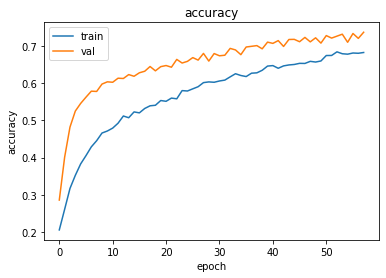

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

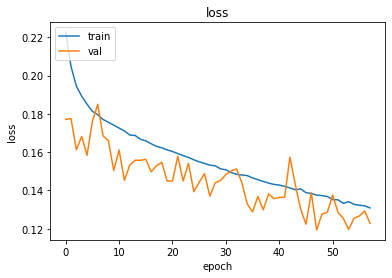

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [33]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 24s 24ms/step


### **Classification Report**

In [36]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[  3   4  20   0   6   5   3]
 [  2  11  14   0  11   5   4]
 [  1   3  62   1  32  24   2]
 [  0   1   3   3   3   5   0]
 [  0   5  25   0  43  34   3]
 [  2   6  35   0  44 555   7]
 [  0   6   1   0   1   1   6]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.38      0.07      0.12        41
         bcc       0.31      0.23      0.27        47
         bkl       0.39      0.50      0.44       125
          df       0.75      0.20      0.32        15
         mel       0.31      0.39      0.34       110
          nv       0.88      0.86      0.87       649
        vasc       0.24      0.40      0.30        15

    accuracy                           0.68      1002
   macro avg       0.46      0.38      0.38      1002
weighted avg       0.70      0.68      0.68      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[  3   4  20   0   6   5   3]
 [  2  11  14   0  11   5   4]
 [  1   3  62   1  32  24   2]
 [  0   1   3   3   3   5   0]
 [  0   5  25   0  43  34   3]
 [  2   6  35   0  44 555   7]
 [  0   6   1   0   1   1   6]]


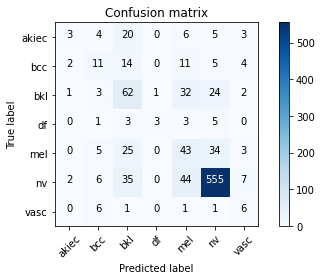

In [37]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [39]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.4286
specificity: 0.8462


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block16_2_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.458
	bkl            	(2)	with probability 0.211
	bcc            	(1)	with probability 0.128
	vasc           	(6)	with probability 0.080
	akiec          	(0)	with probability 0.068
Explanation for 'mel'


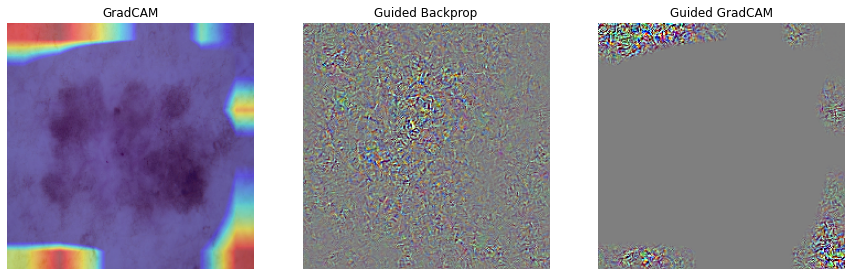

In [42]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.299
	vasc           	(6)	with probability 0.168
	mel            	(4)	with probability 0.146
	bcc            	(1)	with probability 0.118
	bkl            	(2)	with probability 0.100
Explanation for 'nv'


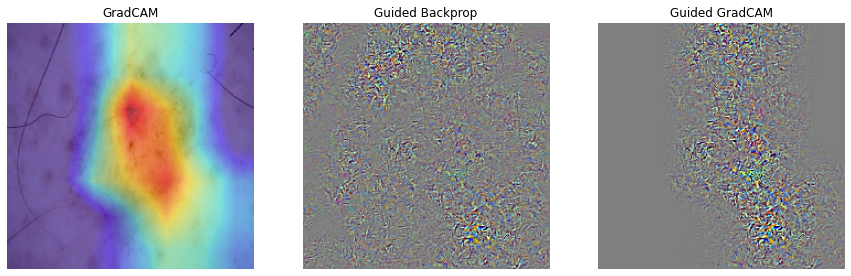

In [44]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.586
	bkl            	(2)	with probability 0.167
	df             	(3)	with probability 0.096
	akiec          	(0)	with probability 0.070
	vasc           	(6)	with probability 0.047
Explanation for 'mel'


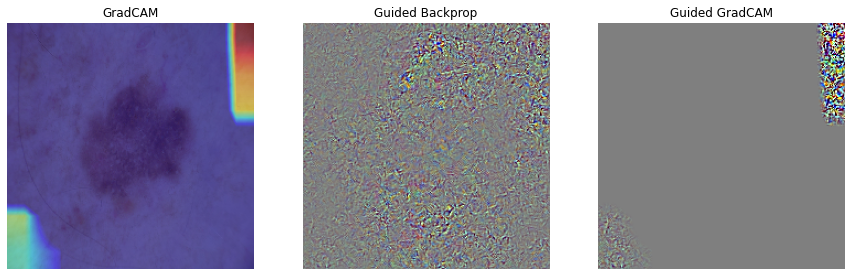

In [46]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.183
	df             	(3)	with probability 0.166
	nv             	(5)	with probability 0.155
	vasc           	(6)	with probability 0.150
	bcc            	(1)	with probability 0.130
Explanation for 'mel'


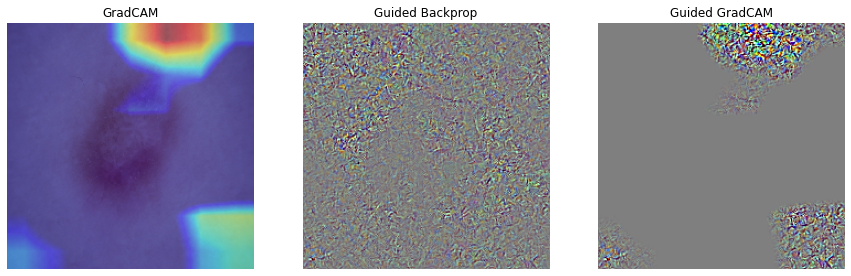

In [48]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.277
	nv             	(5)	with probability 0.174
	bkl            	(2)	with probability 0.154
	df             	(3)	with probability 0.110
	akiec          	(0)	with probability 0.102
Explanation for 'mel'


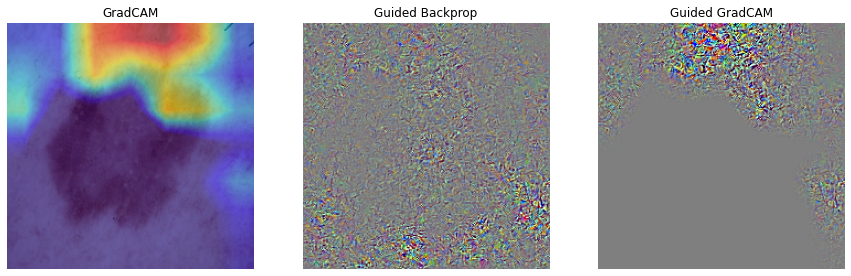

In [50]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.279
	vasc           	(6)	with probability 0.210
	mel            	(4)	with probability 0.163
	bcc            	(1)	with probability 0.110
	df             	(3)	with probability 0.101
Explanation for 'nv'


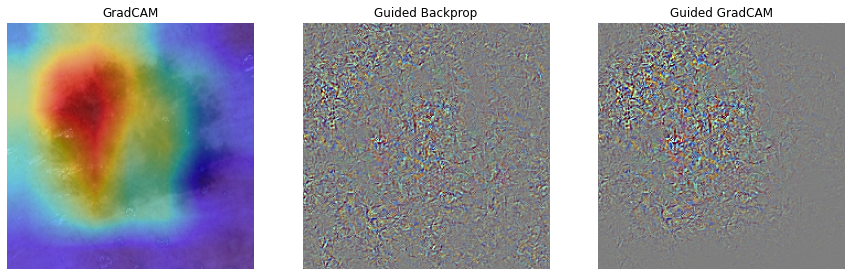

In [52]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	nv             	(5)	with probability 0.577
	vasc           	(6)	with probability 0.107
	df             	(3)	with probability 0.074
	mel            	(4)	with probability 0.062
	bkl            	(2)	with probability 0.060
Explanation for 'nv'


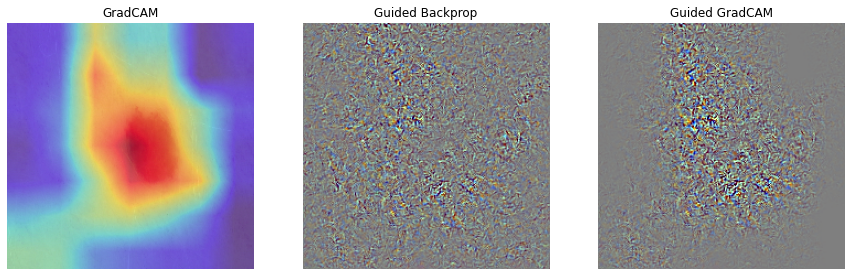

In [54]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [56]:
files.download('/content/Focal-Loss_ResNet50_model.h5')
files.download('/content/Focal-Loss_ResNet50_weights.h5')

FileNotFoundError: ignored